In [1]:
import os
import nibabel as nib
import numpy as np
import random
from tensorflow.keras.utils import to_categorical

2023-05-17 23:52:15.599002: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
image_dir = '/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_images2'
label_dir = '/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_labels2'

output_shape = (128,128,128)
class_num = 8

image_ids = [f.split('_')[2].split('.')[0] for f in os.listdir(image_dir)]
label_ids = [f.split('_')[2].split('.')[0] for f in os.listdir(label_dir)]


In [3]:
def get_image_data(image_paths):
    images = []
    for path in image_paths:
        image = nib.load(path)
        image_data = image.get_fdata()
        images.append(image_data)
    return images


def get_label_data(label_path):
    labels = []
    for path in label_path:
        label = nib.load(path)
        label_data = label.get_fdata()
        labels.append(label_data)
    return labels


def data_generator(image_paths, label_paths, batch_size):

    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_image_paths = image_paths[i:i+batch_size]
            batch_label_paths = label_paths[i:i+batch_size]

            batch_images = get_image_data(batch_image_paths)
            batch_labels = get_label_data(batch_label_paths)
                
            batch_images = np.array(batch_images)
            batch_labels = np.array(batch_labels)
            
            yield batch_images, batch_labels


In [4]:
image_ids = [f.split('_')[2].split('.')[0] for f in os.listdir(image_dir)]
label_ids = [f.split('_')[2].split('.')[0] for f in os.listdir(label_dir)]

np.random.seed(123)
num_epochs = 30
batch_size = 1
val_split = 0.2

for epoch in range(num_epochs):
    np.random.shuffle(image_ids)

    from sklearn.model_selection import train_test_split
    train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=123)

    train_image_paths = [os.path.join(image_dir, f'resized_image_{image_id}.nii') for image_id in train_ids]
    train_label_paths = [os.path.join(label_dir, f'resized_label_{image_id}.nii') for image_id in train_ids]
    val_image_paths = [os.path.join(image_dir, f'resized_image_{image_id}.nii') for image_id in val_ids]
    val_label_paths = [os.path.join(label_dir, f'resized_label_{image_id}.nii') for image_id in val_ids]

    train_steps = len(train_image_paths) // batch_size
    val_steps = len(val_image_paths) // batch_size

    train_generator = data_generator(train_image_paths, train_label_paths, batch_size)
    val_generator = data_generator(val_image_paths, val_label_paths, batch_size)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, Dropout, BatchNormalization, Cropping3D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv3DTranspose

In [6]:
def unet(input_size=(128, 128, 128, 1, 2), binary_model = False):
    inputs = Input((input_size[0], input_size[1], input_size[2], input_size[3]))

    # Downsample path
    conv1 = Conv3D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv3D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv3D(64, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv3D(128, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv3D(256, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv3D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.3)(conv5)
    pool5 = MaxPooling3D(pool_size=(2, 2, 2))(drop5)

    # Bottleneck
    conv6 = Conv3D(1024, 3, activation='relu', padding='same')(pool5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv3D(1024, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    drop6 = Dropout(0.3)(conv6)

    #Decoder
    up7 = Conv3DTranspose(512, 2, strides=(2, 2, 2), padding='same')(drop6)
    merge7 = Concatenate(axis=4)([up7, drop5])
    conv7 = Conv3D(512, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv3D(512, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv3DTranspose(256, 2, strides=(2, 2, 2), activation='relu', padding='same')(conv7)
    merge8 = Concatenate(axis=4)([conv4, up8])
    conv8 = Conv3D(256, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv3D(256, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv3DTranspose(128, 2, strides=(2, 2, 2), activation='relu', padding='same')(UpSampling3D(size=(1, 1, 1))(conv8))
    merge9 = Concatenate(axis=4)([conv3, up9])
    conv9 = Conv3D(128, 3, activation='relu', padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv3D(128, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    up10 = Conv3DTranspose(64, 2, activation='relu', padding='same')(UpSampling3D(size=(2, 2, 2))(conv9))
    merge10 = Concatenate(axis=4)([conv2, up10])
    conv10 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(merge10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)

    up11 = Conv3DTranspose(32, 2, activation='relu', padding='same')(UpSampling3D(size=(2, 2, 2))(conv10))
    merge11 = Concatenate(axis=4)([conv1, up11])
    conv11 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(merge11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv11)
    conv11 = BatchNormalization()(conv11)

    if binary_model:
        outputs = Conv3D(1, (1, 1, 1), activation="sigmoid")(conv11)
    else:
      outputs = Conv3D(8, (1, 1, 1), activation="softmax")(conv11)

    model = Model(inputs, outputs)
    return model

In [9]:
batch_size = 1
train_steps = len(train_image_paths) // batch_size
val_steps = len(val_image_paths) // batch_size

train_data = data_generator(train_image_paths, train_label_paths, batch_size)
val_data = data_generator(val_image_paths, val_label_paths, batch_size)

input_shape = (128, 128, 128, 1)

model = unet(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.MeanIoU(num_classes=2),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_46 (Conv3D)              (None, 128, 128, 128 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 128, 128, 128 128         conv3d_46[0][0]                  
__________________________________________________________________________________________________
conv3d_47 (Conv3D)              (None, 128, 128, 128 27680       batch_normalization_44[0][0]     
____________________________________________________________________________________________

In [10]:

for X, y in train_data:
    print("Train data shape:", X.shape)
    print("Train labels shape:", y.shape)
    break  

for X, y in val_data:
    print("Validation data shape:", X.shape)
    print("Validation labels shape:", y.shape)
    break  

print("Expected input shape of the model:", model.output_shape)

Train data shape: (1, 128, 128, 128, 1)
Train labels shape: (1, 128, 128, 128, 8)
Validation data shape: (1, 128, 128, 128, 1)
Validation labels shape: (1, 128, 128, 128, 8)
Expected input shape of the model: (None, 128, 128, 128, 8)


In [11]:
history = model.fit(
    train_data,
    steps_per_epoch=train_steps,
    epochs=30,
    validation_data=val_data,
    validation_steps=val_steps
)


2023-05-17 23:55:04.820559: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-17 23:55:04.820976: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3695995000 Hz


Epoch 1/30


2023-05-17 23:55:10.528609: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-05-17 23:55:11.827744: W tensorflow/stream_executor/gpu/asm_compiler.cc:98] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2023-05-17 23:55:11.951422: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


14/14 [==============================] - 28s 1s/step - loss: 2.2031 - categorical_accuracy: 0.3997 - mean_io_u_2: 0.4375 - precision_2: 0.1881 - recall_2: 0.0104 - val_loss: 5095179.0000 - val_categorical_accuracy: 0.0016 - val_mean_io_u_2: 0.3756 - val_precision_2: 0.0016 - val_recall_2: 0.0016
Epoch 2/30
14/14 [==============================] - 14s 1s/step - loss: 1.7692 - categorical_accuracy: 0.7730 - mean_io_u_2: 0.4375 - precision_2: 0.7042 - recall_2: 0.0054 - val_loss: 1169632.2500 - val_categorical_accuracy: 0.0042 - val_mean_io_u_2: 0.3765 - val_precision_2: 0.0042 - val_recall_2: 0.0042
Epoch 3/30
14/14 [==============================] - 14s 1s/step - loss: 1.5911 - categorical_accuracy: 0.8903 - mean_io_u_2: 0.4375 - precision_2: 0.7192 - recall_2: 0.0052 - val_loss: 153040.6250 - val_categorical_accuracy: 0.0041 - val_mean_io_u_2: 0.3766 - val_precision_2: 0.0041 - val_recall_2: 0.0041
Epoch 4/30
14/14 [==============================] - 14s 1s/step - loss: 1.4457 - categor

In [12]:
model.save('/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/128_v4_model.h5')

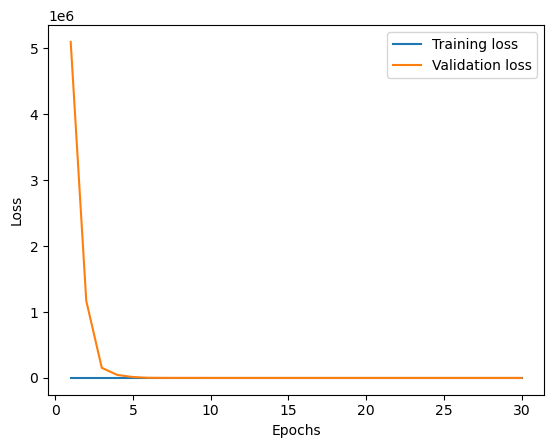

In [13]:
import matplotlib.pyplot as plt

train_losses = history.history['loss']
val_losses = history.history['val_loss']
num_epochs = range(1, len(train_losses) + 1)  

plt.plot(num_epochs, train_losses, label='Training loss')
plt.plot(num_epochs, val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

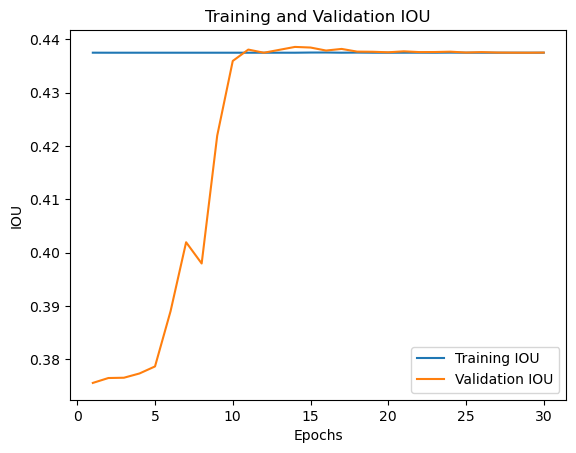

In [15]:
train_iou = history.history['mean_io_u_2']
val_iou = history.history['val_mean_io_u_2']
num_epochs = range(1, len(train_iou) + 1)  

plt.plot(num_epochs, train_iou, label='Training IOU')
plt.plot(num_epochs, val_iou, label='Validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.title('Training and Validation IOU')
plt.legend()
plt.show()


In [17]:
import scipy.ndimage

test_image = '/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_image_1019.nii'
test_image = nib.load(test_image).get_fdata()
resized_test_image = np.expand_dims(test_image, axis=0)


predicted_mask = model.predict(resized_test_image)


In [19]:
ground_truth_mask = '/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_label_1019.nii'
ground_truth_mask = nib.load(ground_truth_mask).get_fdata()


dice = 2 * np.sum(predicted_mask * ground_truth_mask) / (np.sum(predicted_mask) + np.sum(ground_truth_mask))
intersection = np.sum(predicted_mask * ground_truth_mask)
union = np.sum(predicted_mask) + np.sum(ground_truth_mask) - intersection
jaccard = intersection / union

print("Dice coefficient:", dice)
print("Jaccard similarity:", jaccard)


Dice coefficient: 0.9701396397413242
Jaccard similarity: 0.9420108562073879


In [20]:
print(predicted_mask.shape)

(1, 128, 128, 128, 8)


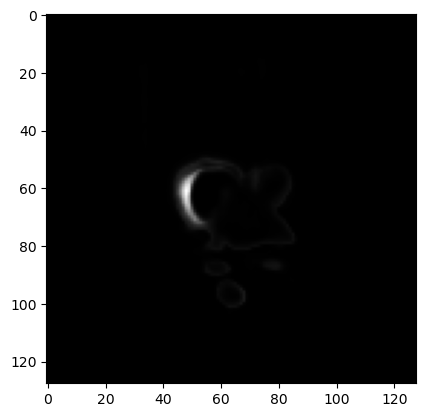

In [43]:
# Select the first channel of the predicted mask
channel = 1
slice_3d = predicted_mask[0, 64, :, :, channel]
plt.imshow(slice_3d, cmap='gray')


In [34]:
print(ground_truth_mask.shape)

(128, 128, 128, 8)


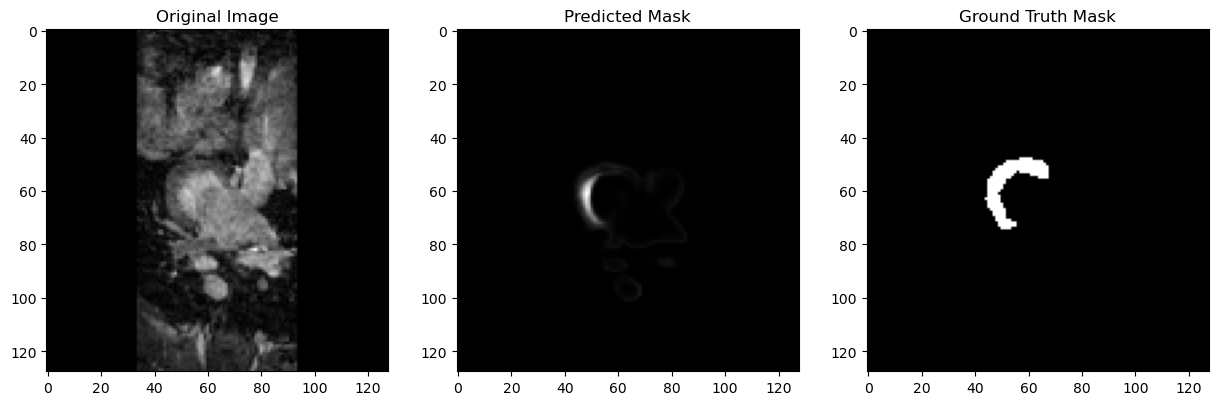

In [53]:
channel = 1
ground_truth_2d = ground_truth_mask[64, :, :, channel]

f, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(test_image[64, :, :], cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(slice_3d, cmap='gray')
ax[1].set_title('Predicted Mask')
ax[2].imshow(ground_truth_2d, cmap='gray')
ax[2].set_title('Ground Truth Mask')

plt.show()


In [48]:
test_image2 = '/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_image_1020.nii'
test_image2 = nib.load(test_image2).get_fdata()
print(test_image2.shape)
resized_test_image2 = np.expand_dims(test_image2, axis=0)

predicted_mask2 = model.predict(resized_test_image2)

(128, 128, 128, 1)


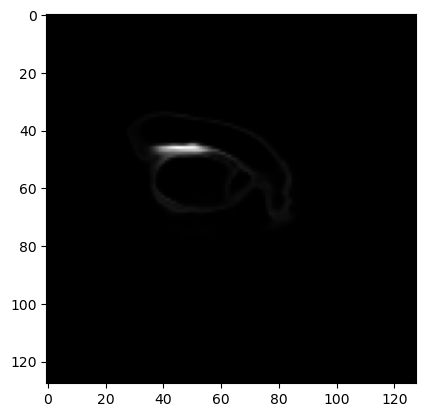

In [61]:
channel = 1
slice2_3d = predicted_mask2[0, :, :, 61, channel]

plt.imshow(slice2_3d, cmap='gray')


In [50]:
ground_truth_mask2 = '/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_label_1020.nii'
ground_truth_mask2 = nib.load(ground_truth_mask2).get_fdata()


dice = 2 * np.sum(predicted_mask2 * ground_truth_mask2) / (np.sum(predicted_mask2) + np.sum(ground_truth_mask2))

intersection = np.sum(predicted_mask2 * ground_truth_mask2)
union = np.sum(predicted_mask2) + np.sum(ground_truth_mask2) - intersection
jaccard = intersection / union

print("Dice coefficient:", dice)
print("Jaccard similarity:", jaccard)


Dice coefficient: 0.968419482876928
Jaccard similarity: 0.9387725599720603


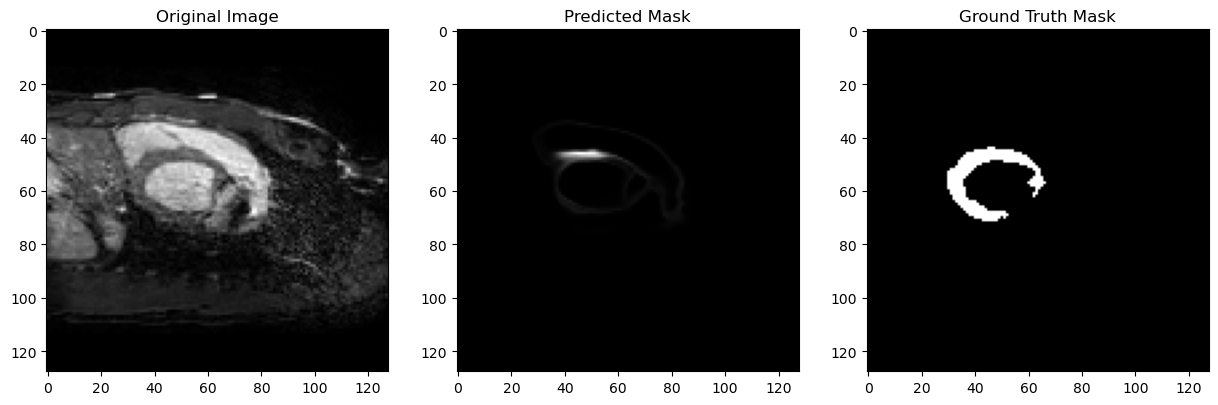

In [62]:
channel = 1
ground_truth2_2d = ground_truth_mask2[:, :, 61, channel]

f, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(test_image2[:, :, 61], cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(slice2_3d, cmap='gray')
ax[1].set_title('Predicted Mask')
ax[2].imshow(ground_truth2_2d, cmap='gray')
ax[2].set_title('Ground Truth Mask')

plt.show()


In [63]:
from sklearn.preprocessing import LabelEncoder

def dsc_calc(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    intersection = np.sum(y_true * y_pred)
    return (2 * intersection) / (np.sum(y_true) + np.sum(y_pred))

def dsc_by_label(y_true, y_pred, label_index):
    return dsc_calc(y_true[:,:,:,label_index], y_pred[:,:,:,label_index])

def label_encoding(label):
    label_encoder = LabelEncoder()
    shape = label.shape
    label = label.reshape(-1)
    label = label_encoder.fit_transform(label)
    label = to_categorical(label, 8)
    label = label.reshape(shape + (8,))
    
    return label

def evaluate(y_true1, y_true2, y_pred1, y_pred2):
    print('Valid 1')
    dsc = dsc_calc(y_true1, y_pred1)
    print('DSC: {0:.4f}'.format(dsc))

    dsc_mean1 = list()
    for i in range(8):
        dsc_i = dsc_by_label(y_true1, y_pred1, i)
        if i!=0:
            dsc_mean1.append(dsc_i)
        print('label_{0:}: {1:.3f}'.format(i, dsc_i))
    print('Average DSC: {0:.3f}'.format(np.mean(dsc_mean1)))

    print('='*50)

    print('Valid 2')
    dsc = dsc_calc(y_true2, y_pred2)
    print('DSC: {0:.4f}'.format(dsc))

    dsc_mean2 = list()
    for i in range(8):
        dsc_i = dsc_by_label(y_true2, y_pred2, i)
        if i!=0:
            dsc_mean2.append(dsc_i)
        print('label_{0:}: {1:.3f}'.format(i, dsc_i))
    print('Average DSC: {0:.3f}'.format(np.mean(dsc_mean2)))
    
    return dsc_mean1, dsc_mean2

In [64]:
import pandas as pd 

def model_evaluate(metric, valid_images):
    exp = pd.read_hdf('/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/128_v4_model.h5')
    exp_image_1 = nib.load('/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_label_1019.nii').get_fdata()
    exp_image_2 = nib.load('/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_label_1019.nii').get_fdata()
    print('exp_image_1 label: ',np.unique(exp_image_1))
    print('exp_image_2 label: ',np.unique(exp_image_2))
    print()
    exp_image_1 = label_encoding(exp_image_1)
    exp_image_2 = label_encoding(exp_image_2)
    print('encoding exp_image_1.shape: ',exp_image_1.shape)
    print('encoding exp_image_2.shape: ',exp_image_2.shape)
    print()

    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].plot(exp['loss'], 'y', label='train loss')
    ax[0].plot(exp['val_loss'], 'r', label='val loss')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].set_ylim([0,1])
    ax[0].legend(loc='upper right')

    ax[1].plot(exp['{}'.format(metric)], 'b', label='train {} coefficient'.format(metric))
    ax[1].plot(exp['val_{}'.format(metric)], 'g', label='val {} coefficient'.format(metric))
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('{}'.format(metric))
    ax[1].set_ylim([0,1])
    ax[1].legend(loc='lower right')

    fig, ax = plt.subplots(2,4, figsize=(20,10))
    for i in range(8):
        ax[i//4,i%4].plot(exp['DSC_{}'.format(i)], 'b', label='train DSC{}'.format(i))
        ax[i//4,i%4].plot(exp['val_DSC_{}'.format(i)], 'r', label='val DSC{}'.format(i))
        ax[i//4,i%4].set_xlabel('epoch')
        ax[i//4,i%4].set_ylabel('Dice Similarity Coefficient')
        ax[i//4,i%4].legend(loc='upper right')
        ax[i//4,i%4].set_ylim([0,1])

    val1_dsc, val2_dsc = evaluate(valid_images[0], valid_images[1], exp_image_1, exp_image_2)
    
    return val1_dsc, val2_dsc

In [65]:
valid_1 = nib.load('/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_label_1019.nii').get_fdata()
valid_2 = nib.load('/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_label_1020.nii').get_fdata()
print('valid_1.shape: ',valid_1.shape)
print('valid_2.shape: ',valid_2.shape)
print()
valid_1 = label_encoding(valid_1)
valid_2 = label_encoding(valid_2)
print('encoding valid_1.shape: ',valid_1.shape)
print('encoding valid_2.shape: ',valid_2.shape)

valid_1.shape:  (128, 128, 128, 8)
valid_2.shape:  (128, 128, 128, 8)

encoding valid_1.shape:  (128, 128, 128, 8, 8)
encoding valid_2.shape:  (128, 128, 128, 8, 8)


In [66]:
import tensorflow.keras as keras

model_architecture = keras.models.load_model('/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/128_v4_model.h5')

# Create an instance of the model using the loaded architecture
model = keras.models.Model.from_config(model_architecture.get_config())

# Load the model weights from the saved file
model.load_weights('/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/128_v4_model.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.MeanIoU(num_classes=2),
                       ])

In [73]:
val1_dsc_exp1, val2_dsc_exp1 = model_evaluate('exp1234', 'UNET_3D', 'dice_coefficient', [valid_1, valid_2])

ValueError: Dataset(s) incompatible with Pandas data types, not table, or no datasets found in HDF5 file.